# Notebook for Coding Excercise

## Implementation of the Tutorial Paper

### 3.2 First Order Differential Equation
#### 3.2.1 Case Study: Fatigue Crack Propagation 

$\frac{da}{dN}=C(\Delta K (t))^m$ where $\Delta K(t) = F\Delta S(t) \sqrt{\pi a(t)}$

where
* a: fatigue crack length
* C and m: material properties coeff
* $\Delta k$: stress intensity rages
* $\Delta s$: far-field cyclic stress time histroy
* F: dimensionless function of geometry

Let us numericaly solve the equation ($\Delta k$) with hybrid method!

Use Euler's forward method
* $a_{n} = a_{0} + \Sigma_{t=1}^{n} \Delta a(\Delta S_{t}, a_{t-1})$
* $\Delta a_t = C \Delta K_{t}^m$
* $\Delta K_t = MLP(\Delta S_t, a_{t-1}; \boldsymbol{w}, \boldsymbol{b})$

The loss function is MSE
* $\Lambda = \frac{1}{n} (\boldsymbol{a}-\boldsymbol{\hat{a}})^T(\boldsymbol{a}-\boldsymbol{\hat{a}})$

$\boldsymbol{a}$ are fatigue crack length.
$\boldsymbol{\hat{a}}$ are predicted value.

In [25]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Dense, Layer, Input
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.framework import tensor_shape
from tensorflow import float32, concat, convert_to_tensor

In [26]:
class EulerIntegratorCell(Layer):
    def __init__(self, C, m, dKlayer, a0=None, units=1, batch_input_shape=None, **kwargs):
        super(EulerIntegratorCell, self).__init__(**kwargs)
        self.units = units
        self.C = C
        self.m = m
        self.dKlayer = dKlayer
        self.a0 = a0
        self.state_size = self.units
        self.output_size = self.units
        self.batch_input_shape = batch_input_shape

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs, states):
        inputs = convert_to_tensor(inputs)
        a_tm1 = convert_to_tensor(states)
        x_d_tm1 = concat((inputs, a_tm1[0, :]), axis=1)
        dk_t = self.dKlayer(x_d_tm1)
        da_t = self.C * (dk_t ** self.m)
        a = da_t + a_tm1[0, :]
        return a, [a]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.a0

In [27]:
class Normalization(Layer):
    def __init__(self, S_low, S_up, a_low, a_up, **kwargs):
        super(Normalization, self).__init__(**kwargs)
        print(kwargs)
        self.lower_bound_S = S_low
        self.upper_bound_S = S_up
        self.lower_bound_a = a_low
        self.upper_bound_a = a_up

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs):
        output = (inputs - [self.lower_bound_S, self.upper_bound_a]) / [(self.upper_bound_S - self.lower_bound_S), (self.upper_bound_a - self.lower_bound_a)]
        return output

In [28]:
def create_model(C, m, a0, dKlayer, batch_input_shape, return_sequences=False, return_state=False):
    euler = EulerIntegratorCell(C=C, m=m, dKlayer=dKlayer, a0=a0, batch_input_shape=batch_input_shape)
    PINN = RNN(cell=euler, return_sequences=return_sequences, return_state=return_state)
    model = Sequential()
    model.add(Input(batch_shape=batch_input_shape))
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e-2))
    return model

Create our model from classes.

In [29]:
# Paris law coefficients
[C, m] = [1.5E-11, 3.8]

# Load Data
Strain = np.asarray(pd.read_csv('./data/Strain.csv'))[:,:,np.newaxis]
atrain = np.asarray(pd.read_csv('./data/atrain.csv'))
a0 = np.asarray(pd.read_csv('./data/a0.csv'))[0,0]*np.ones((Strain.shape[0], 1))

In [30]:
# stress-intensity layer
dKlayer = Sequential()
dKlayer.add(Normalization(np.min(Strain), np.max(Strain), np.min(atrain), np.max(atrain)))
dKlayer.add(Dense(5, activation='tanh'))
dKlayer.add(Dense(1))

# weight initilization
S_range = np.linspace(np.min(Strain), np.max(Strain), 1000)
a_range = np.linspace(np.min(atrain), np.max(atrain), 1000)[np.random.permutation(np.arange(1000))]
dK_range = -12.05 + 0.24 * S_range + 760.0 * a_range

dKlayer.compile(loss='mse', optimizer=RMSprop(1e-2))
input_train = np.transpose(np.asarray([S_range, a_range]))
dKlayer.fit(input_train, dK_range, epochs=100)

# Fitting PINN
model = create_model(C=C, m=m, a0=convert_to_tensor(a0, dtype=float32), dKlayer=dKlayer, batch_input_shape=Strain.shape)
aPred_before = model.predict_on_batch(Strain)[:,:]
model.fit(Strain, atrain, epochs=100, steps_per_epoch=1, verbose=1)
aPred = model.predict_on_batch(Strain)[:,:]

{}
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 899.5873
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 695.6178
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 565.4376
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 483.9333
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 394.5332
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 308.2873
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 276.7026
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 217.0972 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 178.3762 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 135.0634
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 114.8292
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 90.9135
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 77.6970
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 71.6715
Epoch 15/100


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 5.8710e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - loss: 4.6405e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - loss: 3.6048e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - loss: 2.6764e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - loss: 1.8531e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - loss: 1.1467e-04
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - loss: 5.8203e-05
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

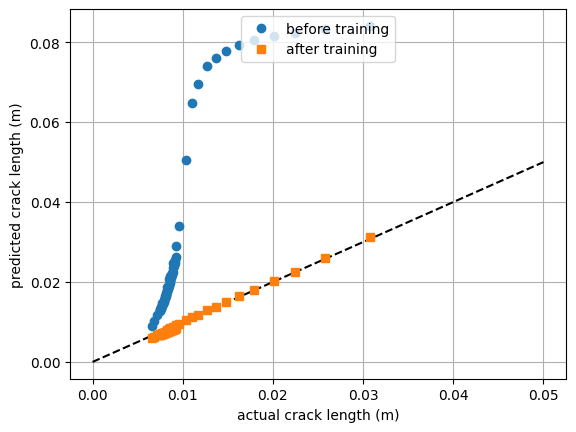

In [31]:
# Plotting prediction
fig = plt.figure()
plt.plot([0,0.05],[0,0.05],'--k')
plt.plot(atrain, aPred_before, 'o', label = 'before training')
plt.plot(atrain, aPred, 's', label = 'after training')
plt.xlabel("actual crack length (m)")
plt.ylabel("predicted crack length (m)")
plt.legend(loc = 'upper center',facecolor = 'w')
plt.grid(which='both')
plt.show()
    